## Understanding Board Context Better

In [ ]:
## we want to see which clues/items on board are producing these types of effects
## define a func that computed similarities of clue to each word on the board
## and then maximizes similarity to the words while minimizing similarity to other words

def speaker_board_func_detailed(combs_df, context_board):
  # grab subset of words in given board and their corresponding glove vectors
  board_df = sample_df[sample_df['Word'].isin(context_board)]
  #print("board_df:",board_df)
  board_word_indices = list(board_df.index)
  board_words = board_df["Word"]
  board_vectors = glovearray[board_word_indices]

  ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
  clue_sims = 1-scipy.spatial.distance.cdist(board_vectors, glovearray, 'cosine')
  #print("clue_sims: ", clue_sims.shape) ## 20 x 12218 

  target_sample = target_df[target_df['Word1'].isin(board_df["Word"]) & target_df['Word2'].isin(board_df["Word"])]
  #print("target_sample:",target_sample)

  w1_index = [list(board_df["Word"]).index(row["Word1"]) for index, row in target_sample.iterrows()]
  w2_index = [list(board_df["Word"]).index(row["Word2"]) for index, row in target_sample.iterrows()]
  clue_w1 = clue_sims[w1_index]
  clue_w2 = clue_sims[w2_index]
  #print("clue_w1:", clue_w1.shape) ## 3 x 12218 sized array 
  #print("clue_w2:", clue_w2.shape) ## 3 x 12218 sized array

  clue_prod = np.multiply(clue_w1,clue_w2)
  #print("clue_prod:", clue_prod.shape) ## 3 x 12218 sized array for each of the word-pairs on the board

  # deleting the two target words to compute average similarity to other words on the board

  clue_sims_new = np.array([np.delete(clue_sims, [w1_index[i], w2_index[i]], axis=0) for i in range(len(w1_index))])
  #print("clue_sims_new:", clue_sims_new.shape)

  avg_sim = np.mean(clue_sims_new, axis=1)
  #print("avg_sim:",avg_sim.shape)

  ## FUNC = alpha(clue_w1*clue_w2) + (1-alpha)*(average of other board words)

  #func = np.subtract((alpha)*clue_prod, (1-alpha)*avg_sim)
  #print("func:", func.shape) ## this is a 3x12218 array where we can find the clue with the highest value for each target word-pair
  
  return clue_prod, avg_sim, clue_sims_new



In [ ]:
cluesims, boardsims, clue_sims_new = speaker_board_func_detailed(board_combos[boardname], boards[boardname])
clue_sims_new.shape

(3, 18, 12218)

['beach', 'box', 'beaker', 'experiment', 'bull', 'milk', 'definition', 'assist', 'oyster', 'necklace', 'pants', 'collar', 'pieces', 'cover', 'tree', 'syrup', 'war', 'quiet', 'welfare', 'conquer']


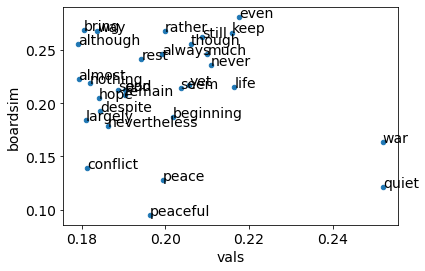

In [ ]:
## glove accuracy decreases if board similarity is completely ignored
## war-quiet is a good example -- "even" and "life" are technically closer to war-quiet, but very similar to other board words
## "peace" is a nice balance
boardname = 'e1_board6_words'

cluesims, boardsims, clue_sims_new = speaker_board_func_detailed(board_combos[boardname], boards[boardname])
idx = 2
clue_sims_main = cluesims[idx]
boardsims_main = boardsims[idx]
## we can find which "clues" have the highest board similarities vs. target similarities
print(boards[boardname])

highest_to_target = (-clue_sims_main).argsort()[:30]
vals = clue_sims_main[highest_to_target]
words = [list(sample_df["Word"])[x] for x in highest_to_target]
boardsim = boardsims_main[highest_to_target]
df = pd.DataFrame({'vals': vals, 'words': [list(sample_df["Word"])[x] for x in highest_to_target], 'boardsim': boardsims_main[highest_to_target]}, index = words)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string

fig, ax = plt.subplots()
df.plot('vals', 'boardsim', kind='scatter', ax=ax)
plt.rcParams.update({'font.size': 14})

for i, txt in enumerate(words):
    ax.annotate(txt, (vals[i], boardsim[i]))

Text(0.5, 1.0, 'WAR-QUIET board similarities')

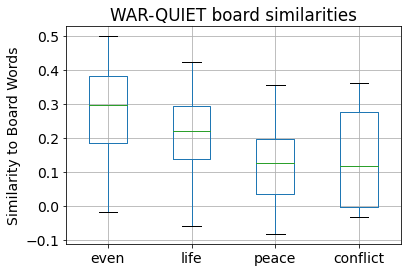

In [ ]:
## also plot similarities of "even", "life", and "peace" to other words on board using clue_sims_new
idx = 2
clue_sims_new_main = clue_sims_new[idx] ## 18 x 12218 array
boardname = 'e1_board6_words'
mainlist = boards[boardname]
#mainlist.remove('war')
#mainlist.remove('quiet')
boardwords_sub = sorted(mainlist) ## clue sims is alphabetical 
c1_index = list(sample_df["Word"]).index('even')
c2_index = list(sample_df["Word"]).index('life')
c3_index = list(sample_df["Word"]).index('peace')
c4_index = list(sample_df["Word"]).index('conflict')

boardsims_clues = clue_sims_new_main[:, [c1_index, c2_index, c3_index, c4_index]]
boardsims_clues
bdf = pd.DataFrame({'even': boardsims_clues[:,0], 'life':boardsims_clues[:,1], 'peace': boardsims_clues[:,2] ,'conflict': boardsims_clues[:,3] }, index = boardwords_sub)
bb = bdf.boxplot()
bb.set_ylabel('Similarity to Board Words')
bb.set_title('WAR-QUIET board similarities')


## Obtain Distance of Prediction from Actual Clue

In [ ]:
## instead of pure accuracy (0/1), we can obtain similarity of prediction to actual modal clue
## read in corrected clues file (excluding stemmed predictions, plurals etc.)
## reading in the words from E1
with tf.device('/device:GPU:0'):
  board_func = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/speaker_boardfunc_df.csv")
board_func.tail()

board_func = board_func.loc[board_func['Model'] == 'BERT-cat']
len(board_func)

715

In [ ]:
def create_similarity_matrix(matrix, vector, N):
  matrix = 1-scipy.spatial.distance.cdist(matrix, vector, 'cosine').reshape(-1)
  matrix = matrix.reshape((N,N))
  return matrix

sim_matrices = {}
for key, embeddings in representations.items() :
  sim_matrices[key] = create_similarity_matrix(embeddings, embeddings, embeddings.shape[0])
  
clue = []
board_func_sample = board_func
for index, row in board_func_sample.iterrows():
  cluesim = row['Model'][list(sample_df["Word"]).index(row["new_pred"]),list(sample_df["Word"]).index(row["topClue"])]
  clue.append(cluesim)
board_func_sample["clue_distance"] = clue
board_func_sample.tail()

,wordpair,Model,alpha,new_pred,new_rsa_acc,topClue,clue_distance
2855,feet-chapel,BERT-cat,1.0,cottage,0,Jesus,0.685187
2856,feet-chapel,BERT-cat,1.0,cottage,0,kneel,0.537605
2857,feet-chapel,BERT-cat,1.0,cottage,0,wash,0.676638
2858,feet-chapel,BERT-cat,1.0,cottage,0,worship,0.679557
2859,chair-table,BERT-cat,1.0,stool,0,furniture,0.771777


In [ ]:
board_func_sample.to_csv("speaker_boardfunc_df_model.csv")
!cp speaker_boardfunc_df_model.csv "drive/My Drive/Connector-RSA-Project/"

# BERT Contextual Analyses

## Guesser

In [ ]:
## using glovearray_answer and gloverray_clue, we can try to see which answer is closest to a given word?

## here we get the data for the experiment
with tf.device('/device:GPU:0'):
  expdata = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/final_board_clues_all.csv", encoding= 'unicode_escape')
expdata.head() ## 1096 rows of data

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra
3,E1,TrialList1,exam,algebra,math,22,exam - algebra
4,E1,TrialList1,exam,algebra,school,2,exam - algebra


In [ ]:
## merge expdata with combined_boards
expdata_new = pd.merge(expdata,combined_boards_df,on=['Board', 'Experiment'],how='left')
expdata_new.head()

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
3,E1,TrialList1,exam,algebra,math,22,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
4,E1,TrialList1,exam,algebra,school,2,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words


In [ ]:
expdata_new

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
3,E1,TrialList1,exam,algebra,math,22,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
4,E1,TrialList1,exam,algebra,school,2,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
...,...,...,...,...,...,...,...,...,...
1091,E2,TrialList9,weird,trauma,strange,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words
1092,E2,TrialList9,weird,trauma,trigger,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words
1093,E2,TrialList9,weird,trauma,uncomfortable,2,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words
1094,E2,TrialList9,weird,trauma,unusual,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words


In [ ]:
answervecs.shape

(20, 768)

In [ ]:
board_combos['e1_board1_words']

,Word1,Word2,wordpair
0,angry,adore,angry-adore
1,angry,burglar,angry-burglar
2,angry,rumor,angry-rumor
3,angry,depth,angry-depth
4,angry,anchor,angry-anchor
...,...,...,...
185,void,yarn,void-yarn
186,void,better,void-better
187,couch,yarn,couch-yarn
188,couch,better,couch-better


In [ ]:
boards['e1_board1_words']

['angry',
 'adore',
 'burglar',
 'rumor',
 'depth',
 'anchor',
 'exam',
 'algebra',
 'giggle',
 'abnormal',
 'instruction',
 'write',
 'outfit',
 'bandanna',
 'pen',
 'lead',
 'void',
 'couch',
 'yarn',
 'better']

In [ ]:
pd.DataFrame({'Word': boards['e1_board1_words']})

,Word
0,angry
1,adore
2,burglar
3,rumor
4,depth
5,anchor
6,exam
7,algebra
8,giggle
9,abnormal


In [ ]:
from scipy.spatial.distance import cosine

def find_closest(clue_vec, answer_vec, context_board):
  # grab subset of words in given board and their corresponding glove vectors
  board_df = pd.DataFrame({'Word': boards[context_board]})
  #print("board_df:",board_df)
  board_word_indices = list(board_df.index)
  board_words = board_df["Word"]
  board_vectors = answer_vec
  combs_df = board_combos[context_board]

  ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
  clue_sims = 1-scipy.spatial.distance.cdist(clue_vec, answer_vec, 'cosine')
  clue_sims = clue_sims.reshape((20,1))

  ## once we have the similarities of the clue to the words on the board
  ## we define a multiplicative function that maximizes these similarities

  ## next we find the product of similarities between c-w1 and c-w2 for that specific board's 190 word-pairs
  ## this gives us a 190 x N array of product similarities for a given combs_df
  ## specifically, for each possible pair, pull out 
  f_w1_list =  np.array([clue_sims[board_df[board_df["Word"]==row["Word1"]].index.values[0]]
                         for  index, row in combs_df.iterrows()])
  f_w2_list =  np.array([clue_sims[board_df[board_df["Word"]==row["Word2"]].index.values[0]] 
                         for  index, row in combs_df.iterrows()])
  
  combs_df["prod"] = f_w1_list * f_w2_list
  return list(combs_df.nlargest(1, ['prod'])["wordpair"])

  # ## we want to get the product of these clue similarities to find the two words with the maximum product
  
  # y = np.array(sims)
  # y_sorted = np.argsort(-y) ## gives sorted indices
  # top20_indices = y_sorted[:5]
  # mainlist = list(np.concatenate(top20_indices).flat)
  # return [board[x] for x in mainlist[:2]]
  #w1 = [list(sample_df["Word"])[i] for i in top20_indices]
  #return top20_indices

In [ ]:
## board1 vecs for calculus
answervecs = glovearray_answer[:20]
## each clue also has "20" embeddings -- corresponding to "clue is most similar to X" where X is each of the 20 words on the board
## we can average these to get an approximate embedding for the clue for that board
cluevec = glovearray_clue[:20].mean(axis=0)
#cluevec = cluevec.mean(axis =0)
print(cluevec.shape)
find_closest(cluevec.reshape((1,768)), answervecs, 'e1_board1_words')

(768,)


['algebra-instruction']

In [ ]:
contextual_bert_guess = []
for index, row in expdata_new.iterrows():
  ## get average "clue" embedding for that board
  clue = row["Clue1"]
  #print("index:", index)
  #print("start:", index*20)
  #print("end:", (index+1)*20)
  ## for each answer there is a unique embedding, so we need to average the 20 embeddings to get an overall clue embedding for the board
  cluevec = glovearray_clue[index*20:(index+1)*20].mean(axis = 0)
  #print(cluevec.shape)
  ## for every clue there are 20 vectors in glovearray_answer
  answervecs = glovearray_answer[index*20:(index+1)*20]
  #print(answervecs.shape)
  guess = find_closest(cluevec.reshape((1,768)), answervecs, row["boardnames"])
  #print(f"for clue {clue}, guess is {guess}")
  contextual_bert_guess.append(guess)

expdata_new["contextual_bert_literal"] = contextual_bert_guess
expdata_new.head()



,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames,contextual_bert_literal
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[algebra-instruction]
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[algebra-bandanna]
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[giggle-instruction]
3,E1,TrialList1,exam,algebra,math,22,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[algebra-instruction]
4,E1,TrialList1,exam,algebra,school,2,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[instruction-outfit]


In [ ]:
expdata_new.tail()


,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames,contextual_bert_literal
1091,E2,TrialList9,weird,trauma,strange,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[weird-happen]
1092,E2,TrialList9,weird,trauma,trigger,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[guest-fly]
1093,E2,TrialList9,weird,trauma,uncomfortable,2,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[weird-sore]
1094,E2,TrialList9,weird,trauma,unusual,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[guest-fly]
1095,E2,TrialList9,weird,trauma,you,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[guest-happen]


In [ ]:
expdata_new.to_csv("guesser_np_bert_contextual.csv")
!cp guesser_np_bert_contextual.csv "drive/My Drive/Connector-RSA-Project/"

In [ ]:
## need to still get RSA-based predictions for this -- but these will depend on speaker analyses. 